# **Import Google Drive**


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Setting**


In [ ]:
from sklearn.isotonic import isotonic_regression
import cvxpy as cp
import numpy as np
import csv, os
from scipy import stats
from sklearn import metrics
import itertools
import pandas as pd
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import statistics
from scipy.stats import levene
import seaborn as sns
import warnings
from sklearn.metrics import r2_score
warnings.filterwarnings("ignore", category=RuntimeWarning)

# Set the text properties to use LaTeX fonts
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['font.size'] = 30
plt.rcParams['figure.figsize'] = (13,8)  # width, height in inches
plt.rcParams['figure.dpi'] = 300  # dots per inch


# **Simple-averaging Isotonic Scores, Proxy**


## Load CSV file into a pandas DataFrame


In [ ]:
# Load CSV file into a pandas DataFrame
df = pd.read_csv(r'/content/drive/MyDrive/Research/ICML_2023_Result/proxy_score.csv')
df = df.drop_duplicates(['submission_id', 'author_id'])

In [ ]:
# Ensure 'rank' is treated as an integer
df['rank'] = df['rank'].astype(int)

k=45
size=round(13.4 * k)
print(size)

# Select 100 random authors
random_authors = np.random.choice(df['author_id'].unique(), size=size, replace=False)

In [ ]:
# Create a new column 'new_rank' initialized with original 'rank'
df['new_rank'] = df['rank']

# Shuffle rankings for selected authors
for author in random_authors:
    author_papers = df[df['author_id'] == author].copy()
    # shuffled_ranks = np.random.permutation(author_papers['rank'].values)
    shuffled_ranks = author_papers['rank'].values[::-1]
    df.loc[df['author_id'] == author, 'new_rank'] = shuffled_ranks

## Organize each block by {author: [submission, rank, score]}.


In [ ]:
author_submission_rank_old = {}
authors = df['author_id'].unique()
for author in authors:
    author_submission_rank_old[author] = []
    submissions = list(set(df[df['author_id'] == author]['submission_id'].tolist()))

    for i in range(len(submissions)):
        rank = df[(df['submission_id'] == submissions[i]) & (df['author_id'] == author)]['new_rank'].tolist()[0]
        ratings = df[(df['submission_id'] == submissions[i]) & (df['author_id'] == author)]['rating_0312_mean'].tolist()[0]
        author_submission_rank_old[author].append((submissions[i], rank, ratings))

## Sort submissions by rank; in case of ties, sort by score.


In [ ]:
def sort_submissions(author_submission_rank_old):
    for author in author_submission_rank_old:
        author_submission_rank_old[author].sort(key=lambda x: (x[1], -x[2]), reverse=False)
    return author_submission_rank_old

author_submission_rank_old = sort_submissions(author_submission_rank_old)

## Compute isotonic scores for each author.


In [ ]:
author_submission_rank_new = {}
for author in author_submission_rank_old:
    ir_rank = []
    for i in range(len(author_submission_rank_old[author])):
        r1 = author_submission_rank_old[author][i][2]
        ir_rank.append(r1)
    ir_rank = np.array(ir_rank)
    ir_rank_pred =  isotonic_regression(ir_rank, sample_weight = None, y_min=0.0, y_max=10.0, increasing=False)

    author_submission_rank_new[author] = []
    for i in range(len(author_submission_rank_old[author])):
        author_submission_rank_new[author].append((author_submission_rank_old[author][i][0], author_submission_rank_old[author][i][1], ir_rank_pred[i]))


## For multi-author submissions, average the scores to get the isotonic score.


In [ ]:
final_submission_list = df['submission_id'].unique()

submission_new_rating = {}
for submission in final_submission_list:
    submission_new_rating[submission] = []

for author in author_submission_rank_new:
    for i in range(len(author_submission_rank_new[author])):
      if author_submission_rank_new[author][i][0] in final_submission_list:
        submission_new_rating[author_submission_rank_new[author][i][0]].append(author_submission_rank_new[author][i][2])

for submission in final_submission_list:
    submission_new_rating[submission] = [float(rating) for rating in submission_new_rating[submission]]
    avg_rating = sum(submission_new_rating[submission])/len(submission_new_rating[submission])
    submission_new_rating[submission] = avg_rating

In [ ]:
# Isotonic score
adhoc_iso_rating = {}
for submission in final_submission_list:
  adhoc_iso_rating[submission] = submission_new_rating[submission]

# Overlap Rate

In [ ]:
# Load the dataset (replace 'your_file.csv' with the actual file path)
df = pd.read_csv(r'/content/drive/MyDrive/Research/ICML_2023_Result/proxy_score.csv')
# Drop duplicate submission_id entries, keeping the first occurrence
df = df.drop_duplicates(subset='submission_id', keep='first')
df_dec = pd.read_csv("/content/drive/MyDrive/Research/ICML_2023_Result/rank_author_dec.csv")

# Create a dictionary mapping submission_id to decision
decision_dict = dict(zip(df_dec['submission_id'], df_dec['decision']))

# Find submissions with decision "Accept (Oral & Poster)"
oral = [submission for submission in df['submission_id'].unique() if decision_dict.get(submission, '') == 'Accept (Oral & Poster)']


In [ ]:
# Sort df by 'rating_0312_mean' in descending order
df_sorted = df.sort_values(by='rating_0312_mean', ascending=False)

In [ ]:
count = int(81)
print(count)

# Select the top 81 submission_id based on sorted 'rating_0312_mean'
top_raw = df_sorted['submission_id'].head(count).tolist()

# Select top 81 submission_id based on isotonic scores from adhoc_iso_rating
top_iso = sorted(adhoc_iso_rating, key=adhoc_iso_rating.get, reverse=True)[:count]

overlap_iso_count = len(set(top_iso) & set(oral))
print("Isotonic Scores:", overlap_iso_count)

overlap_raw_count = len(set(top_raw) & set(oral))
print("Raw Scores:", overlap_raw_count)

overlap_total_count = len(set(top_raw) & set(top_iso) & set(oral))
print("Both:", overlap_total_count)
print("Additional:", overlap_iso_count - overlap_total_count)
print('*'*10)

# Plot

In [ ]:
changes = [0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50]
iso_overlap = [32, 31, 30, 27, 26, 25, 23, 23, 19, 20, 19]

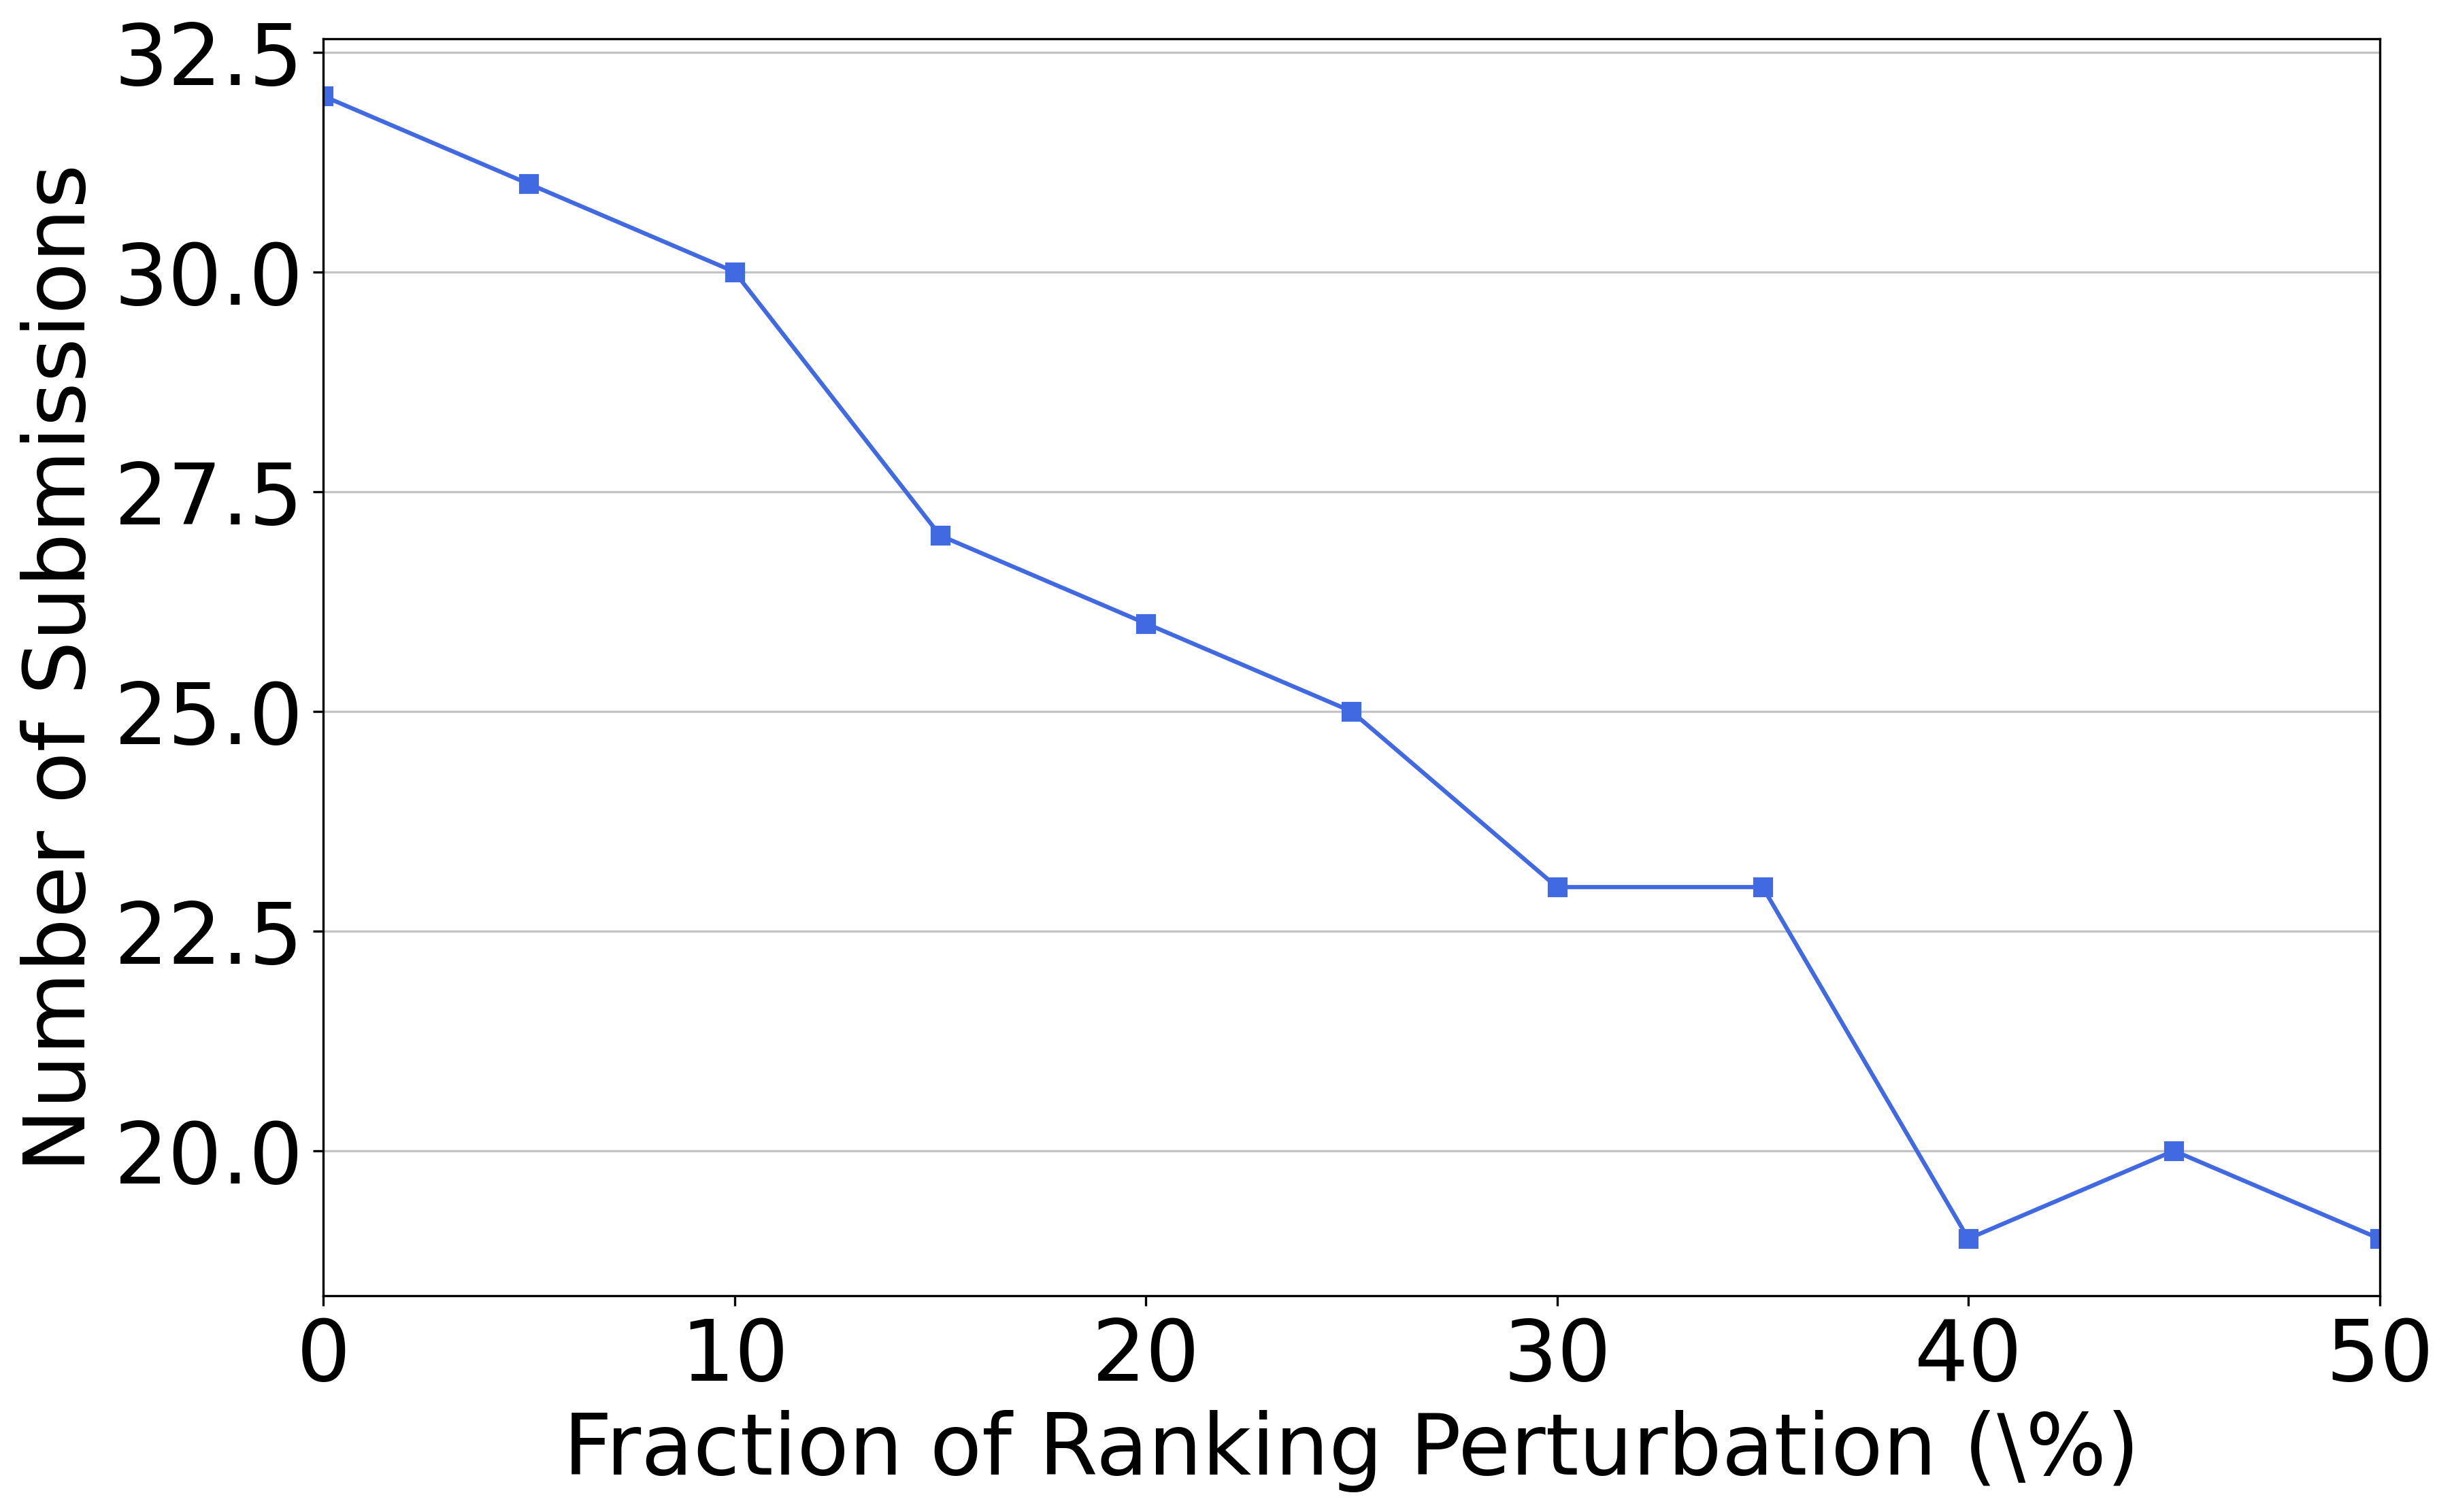

In [ ]:
fig = plt.figure()

plt.plot(changes, iso_overlap,'s-',color = 'royalblue',label="ATT-RLSTM")

# # Add the numbers on top of each bar
# for i, v in enumerate(count):
#     plt.text(i, v, str(v), ha='center', va='bottom')

plt.xlabel("Fraction of Ranking Perturbation (\\%)")
plt.ylabel("Number of Submissions")
plt.xlim(0, 50)
plt.xticks()
plt.yticks()

plt.grid(axis='y', alpha=0.75)
plt.savefig("/content/drive/MyDrive/Research/ICML_2023_Result/Figures/perturbation_overlap_oral.svg", bbox_inches='tight')
plt.show()
